In [557]:
import random
import torch
import string
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [567]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [559]:
allowed_chars = string.digits + '+' + 'b' + 'p' + 'e'
eos_token_id = allowed_chars.index("e") 
padding_token_id = allowed_chars.index("p")


class Generator:
    def __init__(self) -> None:
        pass

    def sample(self):
        s1 = random.randint(100, 99999)
        s2 = random.randint(100, 99999)
        r = s1 + s2
        input = f"{s1}+{s2}e"
        output = f"b{r}e"
        return self.string_to_tensor(input), self.string_to_tensor(output)

    def batch(self, n):
        inputs = []
        outputs = []
        for _ in range(n):
            input, output = self.sample()
            inputs.append(input)
            outputs.append(output)
        return inputs, outputs

    def string_to_tensor(self, s):
        tensor = torch.zeros(len(s), len(allowed_chars))
        for i, char in enumerate(s):
            tensor[i, allowed_chars.index(char)] = 1
        return tensor

    def tensor_to_string(self, tensor):
        _, max_idx = tensor.max(1)
        return ''.join([allowed_chars[i] for i in max_idx])

    def batch_to_tensor(self, n):
        seq_in = []
        seq_out = []
        inputs, outputs = self.batch(n)
        for input, output in zip(inputs, outputs):
            seq_in.append(input)
            seq_out.append(output)
        return pad_sequence(seq_in, batch_first=True), pad_sequence(seq_out, batch_first=True)

In [560]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x, hidden):
        output, (hidden, cell) = self.rnn(x, hidden)
        return output, (hidden, cell)

In [561]:
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_hidden_states = None
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def assign_encoder_hidden_states(self, hidden_states) -> None:
        self.encoder_hidden_states = hidden_states

    def calculate_score(self, decoder_hidden_states):
        return torch.bmm(decoder_hidden_states, self.encoder_hidden_states.transpose(1, 2))

    def source_context(self, decoder_hidden_states):
        return self.softmax(self.calculate_score(decoder_hidden_states))

    def forward(self, decoder_hidden_state):
        return self.source_context(decoder_hidden_state)


In [562]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.rnn(x, (hidden, cell))
        return output, (hidden, cell)

In [563]:
import torch
import torch.nn as nn

class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = Encoder(input_size, hidden_size)
        self.attention = Attention()
        self.decoder = Decoder(hidden_size, hidden_size)
        self.reduce_dimension = nn.Linear(hidden_size, 12)
        self.output = nn.Linear(12, output_size)
        self.eos_token_id = eos_token_id
        self.pad_token_id = padding_token_id
        self.max_length = 8
    
    def forward(self, input, hidden=None):
        output_enc, (hn_enc, cn_enc) = self.encoder(input, hidden)
        output_seq = []
        decoder_input = hn_enc[0].unsqueeze(1)
        self.attention.assign_encoder_hidden_states(output_enc)
        for _ in range(self.max_length):
            out_dec, (hn_dec, cn_dec) = self.decoder(decoder_input, hn_enc, cn_enc)
            attention_output = self.attention(out_dec).squeeze()
            decoder_output = self.reduce_dimension(out_dec[:, -1, :])
            output = self.output(attention_output * decoder_output)
            output_seq.append(output)
            if (decoder_output.argmax(dim=1) == self.eos_token_id).all(): break
            decoder_input = out_dec
            hn_enc, cn_enc = hn_dec, cn_dec
        if len(output_seq) < self.max_length:
            output_seq.append(torch.full((input.size(0), self.max_length - len(output_seq), self.output.out_features), self.pad_token_id))
        return torch.stack(output_seq, dim=1)

In [564]:
model = Seq2Seq(input_size=len(allowed_chars), hidden_size=128, output_size=len(allowed_chars))

Epoch: 0, Loss: 0.08430000394582748
Epoch: 100, Loss: 0.04670019820332527
Epoch: 200, Loss: 0.040669891983270645
Epoch: 300, Loss: 0.03898271545767784
Epoch: 400, Loss: 0.038527946919202805
Epoch: 500, Loss: 0.03732884302735329
Epoch: 600, Loss: 0.036869145929813385
Epoch: 700, Loss: 0.03573039919137955
Epoch: 800, Loss: 0.036123137921094894
Epoch: 900, Loss: 0.035120658576488495
Epoch: 1000, Loss: 0.03578906133770943
Epoch: 1100, Loss: 0.03510967642068863
Epoch: 1200, Loss: 0.03481636941432953
Epoch: 1300, Loss: 0.03353101387619972
Epoch: 1400, Loss: 0.034614138305187225
Epoch: 1500, Loss: 0.03307612985372543
Epoch: 1600, Loss: 0.03299401327967644
Epoch: 1700, Loss: 0.03278772905468941
Epoch: 1800, Loss: 0.0331982746720314
Epoch: 1900, Loss: 0.032977890223264694
Epoch: 2000, Loss: 0.03260519728064537
Epoch: 2100, Loss: 0.03196762874722481
Epoch: 2200, Loss: 0.03317094221711159
Epoch: 2300, Loss: 0.03248590603470802
Epoch: 2400, Loss: 0.03248710557818413
Epoch: 2500, Loss: 0.0318463854

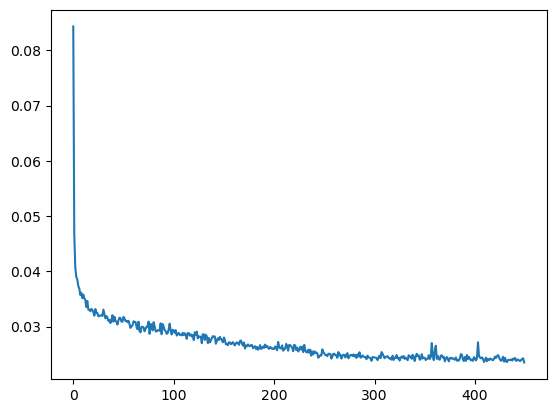

In [565]:
history = []

def train(model, optimizer, loss_fn, n_epochs, batch_size):
    for epoch in range(n_epochs):
        total_loss = 0
        optimizer.zero_grad()
        x, y = dg.batch_to_tensor(batch_size)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if epoch % 100 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss))
            history.append(total_loss)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
dg = Generator()

train(model, optimizer, loss_fn, 45_000, 128)
plt.plot(history, label='loss')

In [566]:
def evaluate(model, n):
    x, y = dg.batch_to_tensor(n)
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    for i in range(n):
        print(dg.tensor_to_string(x[i]), dg.tensor_to_string(y_pred[i]), dg.tensor_to_string(y[i]))

evaluate(model, 10)

39060+87026e b126244e b126086e
59326+11589e b70894e4 b70915e0
36501+46882e b83244e4 b83383e0
39336+45649e b84894e4 b84985e0
6168+52949e0 b59244e4 b59117e0
2483+53031e0 b55244e4 b55514e0
11572+66270e b77894e4 b77842e0
10700+20129e b30894e4 b30829e0
92206+33963e b126244e b126169e
29489+96533e b126244e b126022e
